In [133]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [134]:
# !pip install --upgrade statsmodels

In [135]:
# !python -m pip install --upgrade pip

# Time Series Question 1
Discuss the concept and application of Time series analysis using machine learning modelling by providing a real-world data set. What is the purpose of The Augmented Dickey-Fuller test in time series?

a) Apply an appropriate Box-Jenkins model to the chosen dataset (ARMA, ARIMA, SARIMA etc). Check for the model adequacy.

b) Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors.

c) Make a time series plot of the data, and further calculate and illustrate the sample autocorrelation and partial 
autocorrelation (PA). Is there significant autocorrelation in the chosen time series?


In [136]:
# import libraries and packages
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import itertools


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Import Data and begin basic observations (EDA)

In [137]:
# import data set
# identify if there are missing values
missing_value_formats = ["x",'']
df = pd.read_csv('Microsoft_Stock.csv', header = 0, na_values = missing_value_formats)

In [138]:
print(df.head())

                Date   Open   High    Low  Close    Volume
0  4/1/2015 16:00:00  40.60  40.76  40.31  40.72  36865322
1  4/2/2015 16:00:00  40.66  40.74  40.12  40.29  37487476
2  4/6/2015 16:00:00  40.34  41.78  40.18  41.55  39223692
3  4/7/2015 16:00:00  41.61  41.91  41.31  41.53  28809375
4  4/8/2015 16:00:00  41.48  41.69  41.04  41.42  24753438


In [139]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB
None


In [140]:
print(df.describe())

              Open         High          Low        Close        Volume
count  1511.000000  1511.000000  1511.000000  1511.000000  1.511000e+03
mean    107.385976   108.437472   106.294533   107.422091  3.019863e+07
std      56.691333    57.382276    55.977155    56.702299  1.425266e+07
min      40.340000    40.740000    39.720000    40.290000  1.016120e+05
25%      57.860000    58.060000    57.420000    57.855000  2.136213e+07
50%      93.990000    95.100000    92.920000    93.860000  2.662962e+07
75%     139.440000   140.325000   137.825000   138.965000  3.431962e+07
max     245.030000   246.130000   242.920000   244.990000  1.352271e+08


In [141]:
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


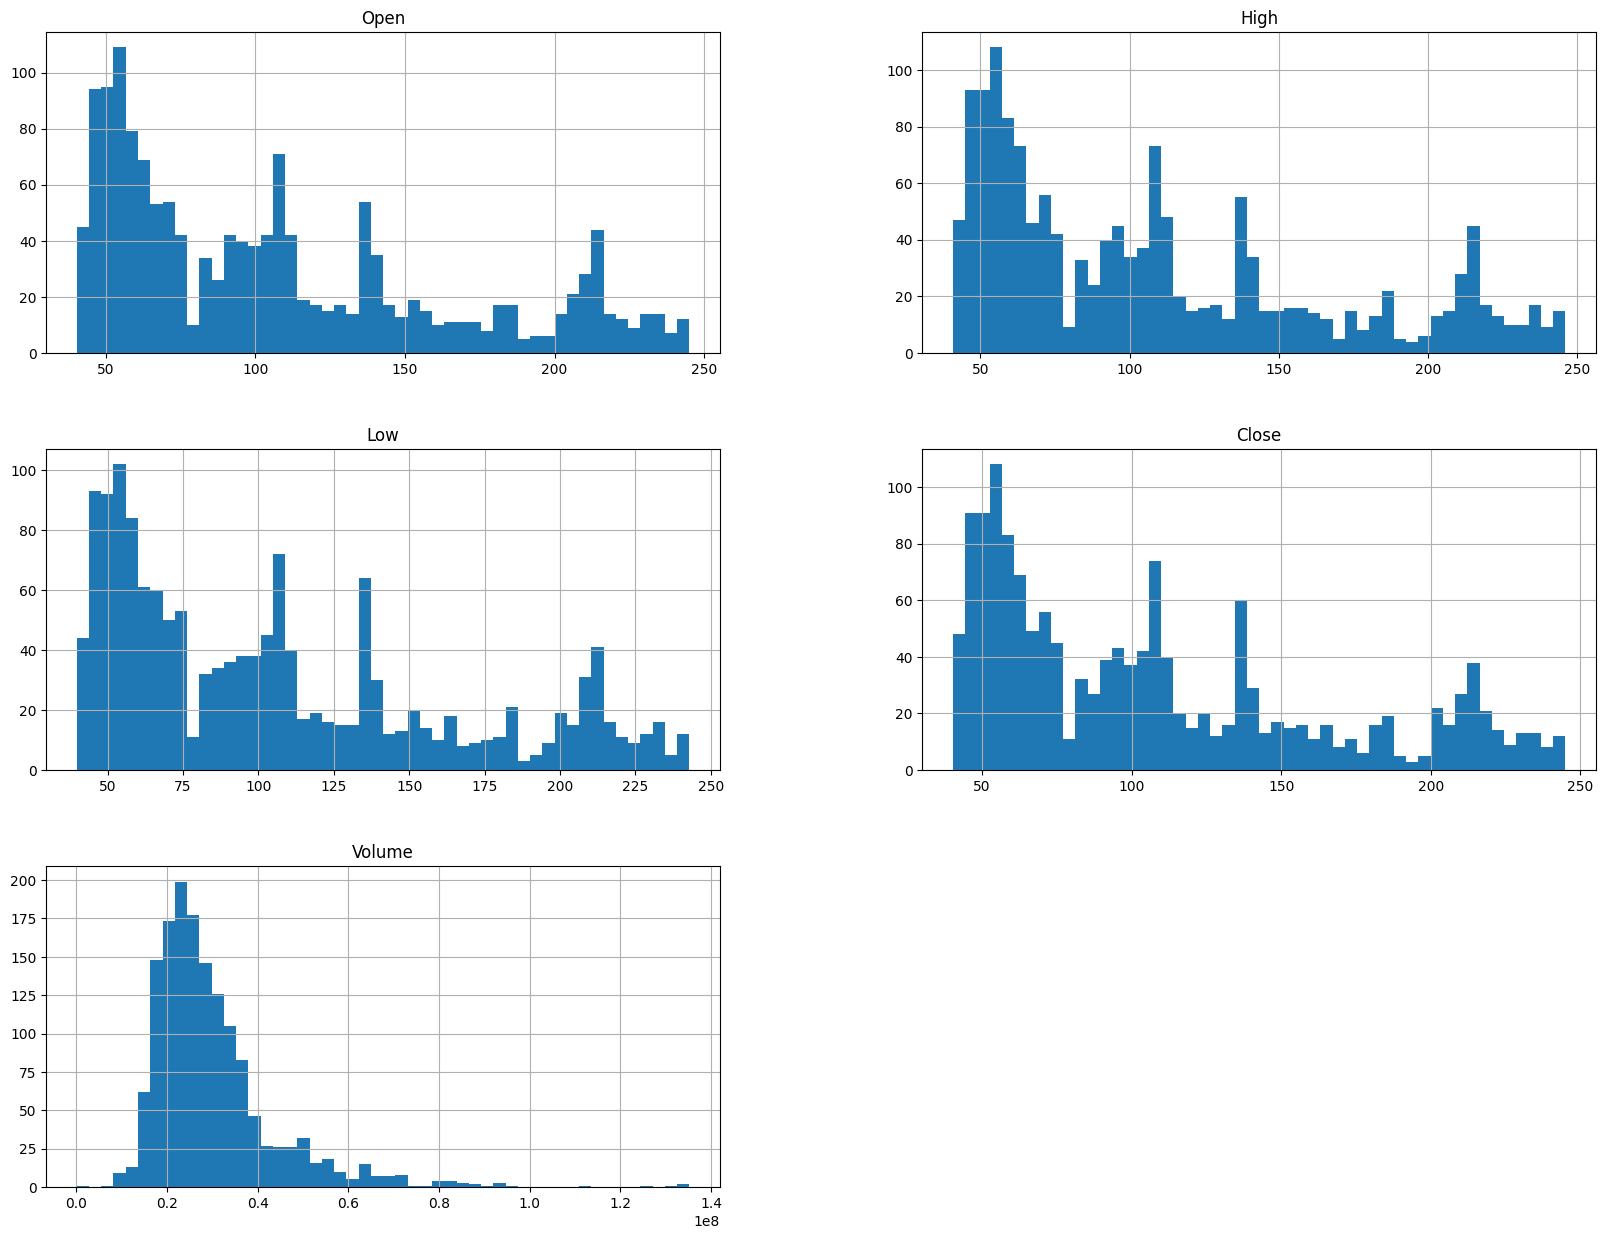

In [142]:
# plot the data
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [143]:
# Convert the 'Date' column in the DataFrame df to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index of df
df.set_index('Date', inplace=True)

# new 'time_series' create 'Close' column 
time_series = df['Close'] 

### Augmented Dickey-Fuller test

Testing to see if the dataset is stable  or not using the dicke duller test. 

The test will show a negative number if the dataset is stable and the the hiher the negative value the more unstable it is.

If it is unstable I will need to use differencing to stabalise the dataset.

In [144]:
# Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
test_stationarity(time_series)

Results of Dickey-Fuller Test:
Test Statistic                    1.737136
p-value                           0.998216
#Lags Used                       24.000000
Number of Observations Used    1486.000000
Critical Value (1%)              -3.434758
Critical Value (5%)              -2.863487
Critical Value (10%)             -2.567807
dtype: float64


The Dickey_Fuller test results show that the time series is not stationary, as the p-value is greater than 0.05

Also the Test Statistic is greater thanthe Critical Value 

Test Statistic              =   1.737136 

Critical Value (1%)         =   -3.434758 

Critical Value (5%)         =   -2.863487

Critical Value (10%)        =   -2.567807


Will use differencing to stabalise the data prior to runing Arima etc.

In [145]:
# Differencing the time_series to ensure the data is stationary prior to modelling
diff_time_series = time_series.diff().dropna()

# Run test again
test_stationarity(diff_time_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.003833e+01
p-value                        1.519594e-17
#Lags Used                     2.400000e+01
Number of Observations Used    1.485000e+03
Critical Value (1%)           -3.434761e+00
Critical Value (5%)           -2.863488e+00
Critical Value (10%)          -2.567807e+00
dtype: float64


### Plot the Autocorrelation

Autocorrelation Function (ACF) Plot: Visualising how the data points in the time series correlate with each other at different lags 

Partial Autocorrelation Function (PACF) Plot: Visualising how the data points partially correlated at shorter lags

I start with 50 as the time interval, however the blue line crossing over the shaded blue area needs to be observed, 

I will do a second plot with a value of 200 as the time interval (lag)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

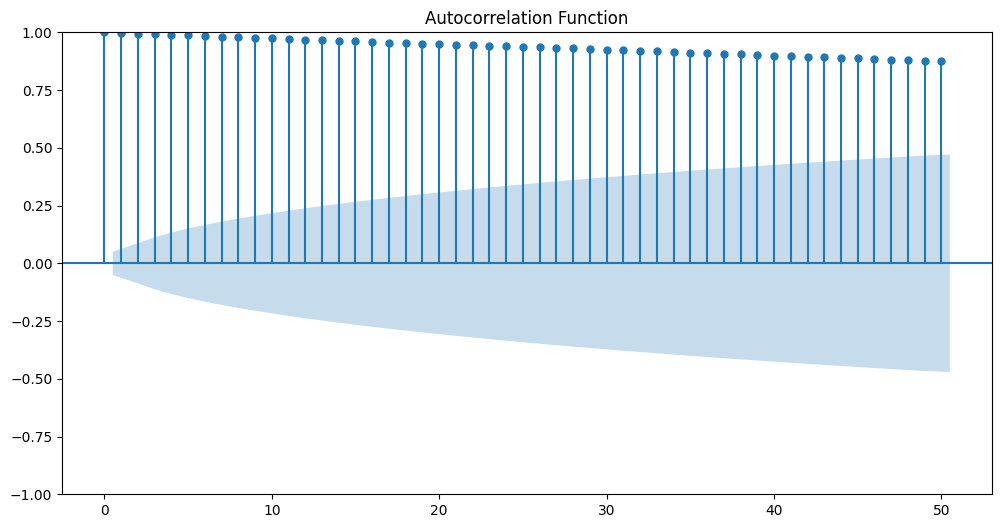

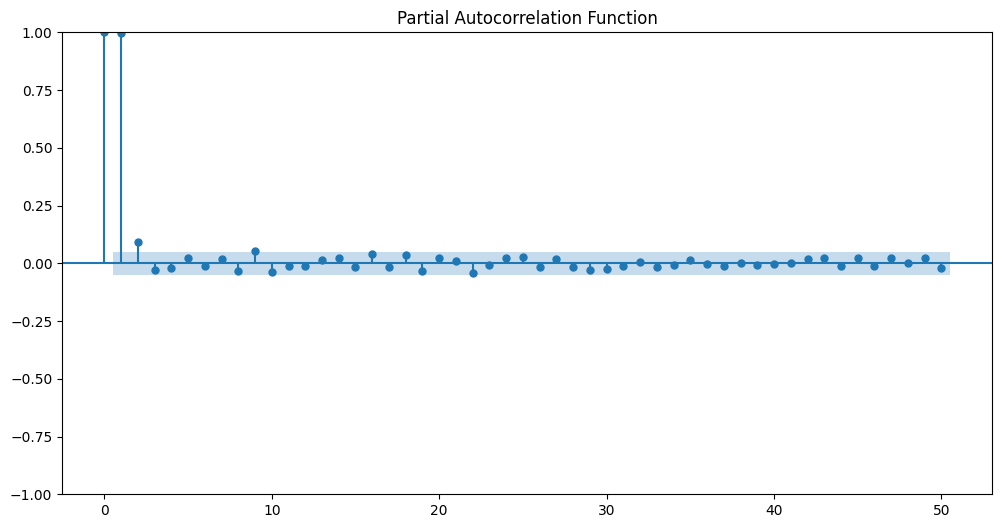

In [146]:
# Plot ACF prior to fitting ARIMA model
plt.figure(figsize=(12,6))
plot_acf(df['Close'], ax=plt.gca(), lags=50)
plt.title('Autocorrelation Function')

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(df['Close'], ax=plt.gca(), lags=50)
plt.title('Partial Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

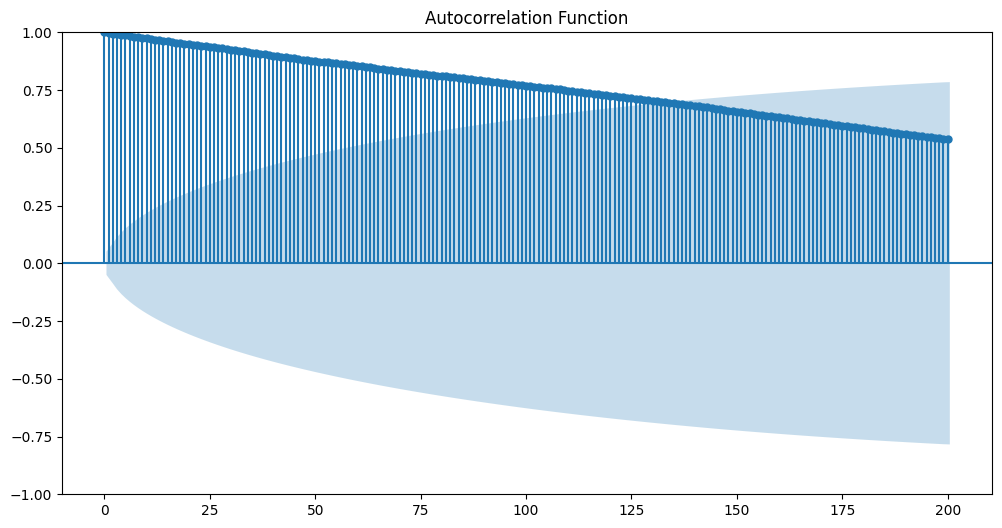

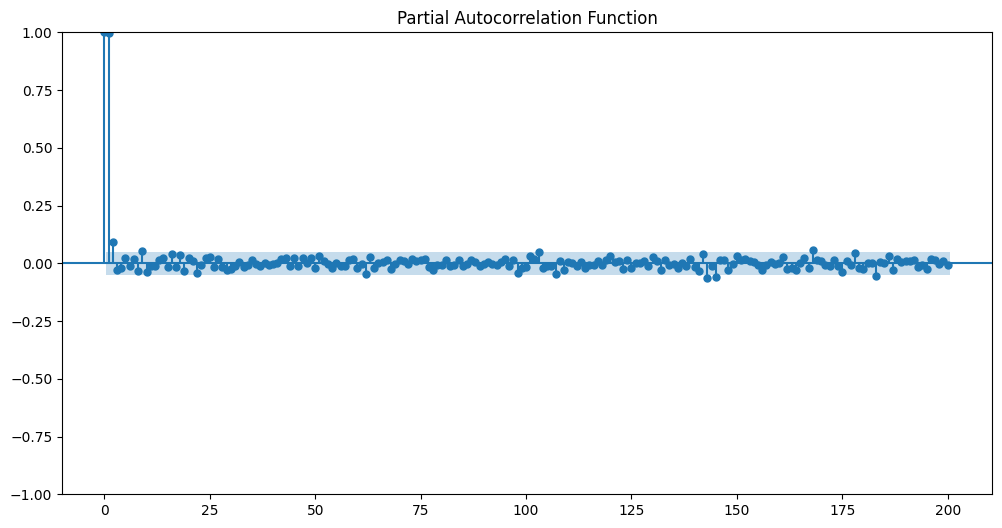

In [147]:
# Plot ACF prior to fitting ARIMA model
plt.figure(figsize=(12,6))
plot_acf(df['Close'], ax=plt.gca(), lags=200)
plt.title('Autocorrelation Function')

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(df['Close'], ax=plt.gca(), lags=200)
plt.title('Partial Autocorrelation Function')

Oberservation of ACF

As the decline is gradual as the lag increases, close price is higly autocorrelated at short lags but increases as the lag increases

Observation of PCAF, shows a spike at 1 and is followed by nothing really signeificant. suggest to use p=1 for the Arima model tht i running first.

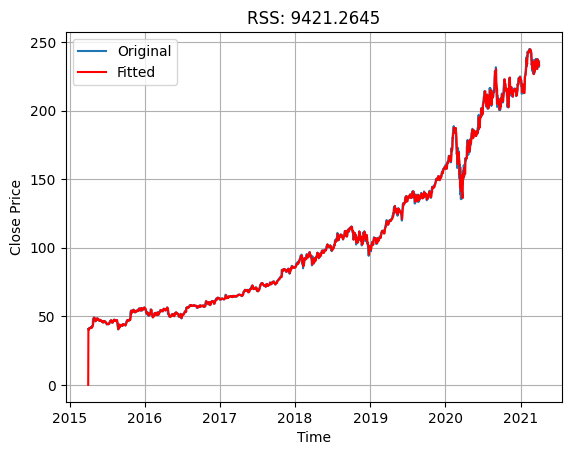

In [148]:
# Fitting the Arima model to 'Close', choosing Arima as as seasonality is not present as such, 
model = ARIMA(df['Close'], order=(5,1,0))
results_ARIMA = model.fit()

# Plot the original data
plt.plot(df['Close'], label='Original')
plt.xlabel('Time')
plt.ylabel('Close Price')

# Plot the fitted values
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted')

plt.grid(True)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df['Close'])**2))
plt.legend()

plt.show()

### Akaike information criterion (AIC)
Upoon running my original code I understood that I had not fully understood how to fit the data using Arima.

I had choosen Arima based on my original oberservation of no real seasonality shwon in the plots.

I found AIC, I found this method to assist me in right sizinf for p, q & d. however I realised I needed to find the optimum calue for p,q & d also. 
Needed to understand how to fit the model https://www.scribbr.com/statistics/akaike-information-criterion/

Using https://docs.python.org/3/library/itertools.html to understand effiecient looping of the values

#Needed to understand how to fit the model https://www.scribbr.com/statistics/akaike-information-criterion/

In [149]:
# Initialize an empty list to store the AIC values and corresponding p, d, q values
aicVals = []

# Loop p, d, and q for the ARIMA model, based on AIC premium number is 2
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                # Fit an ARIMA model in order (p, d, q) & calculate the AIC value
                aic = sm.ARIMA(df["Close"], order=(p,d,q)).fit().aic
                
                # Append the AIC and corresponding p, d, q values to the list
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                # If the ARIMA model cannot be fitted due to a Linear Algebra error, skip this combination of p, d, q
                pass

# Sort p, d, q values in ascending order of AIC
aicVals.sort()

# Print the best AIC 
print(f"Best AIC: {aicVals[0][0]}")
print(f"Best parameters: {aicVals[0][1:]}")

Best AIC: 6751.747544954895
Best parameters: [2, 2, 2]


Based on above AIC the best values are 2, 2, 2 for p,d,q

Point to note is statsmodels uses Sarimax to fit Arima and Sarimax hence output below stats Sarimax even though this 

In [162]:
# Define the best parameters
p, d, q = 2,2,2

# Fit an ARIMA model in order (p, d, q)
model = ARIMA(df["Close"], order=(p, d, q))

# Fit the model
results_ARIMA = model.fit()

# Print the summary of the model
print(results_ARIMA.summary())
# Print the information you're interested in
print(f"ARIMA({p},{d},{q})")
print(f"AIC: {results_ARIMA.aic}")
print(f"BIC: {results_ARIMA.bic}")
print(f"HQIC: {results_ARIMA.hqic}")

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -3370.874
Date:                Sat, 25 Nov 2023   AIC                           6751.748
Time:                        18:13:52   BIC                           6778.344
Sample:                             0   HQIC                          6761.653
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1711      0.029    -40.613      0.000      -1.228      -1.115
ar.L2         -0.2909      0.010    -30.329      0.000      -0.310      -0.272
ma.L1         -0.1054      0.029     -3.579      0.0

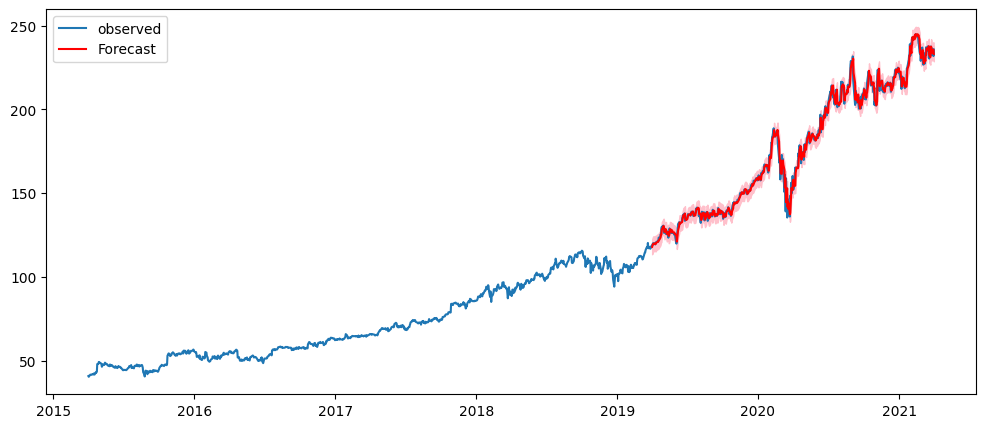

In [163]:
# Make predictions
pred = results_ARIMA.get_prediction(start=pd.to_datetime('2019-04-01 16:00:00'), dynamic=False)

# Get the confidence intervals of the predictions
pred_conf = pred.conf_int()

# Plot the original data and the forecasted data
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='observed')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, color='red', label='Forecast')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
plt.legend()
plt.show()

As you can see their peaks and troughs in 2020, this would mean that the time series would be more diffilcut to predict during this time, 

Upon further investigation I can assume this is down to the beginning of Covi-19 and the uncertainty in the market, 

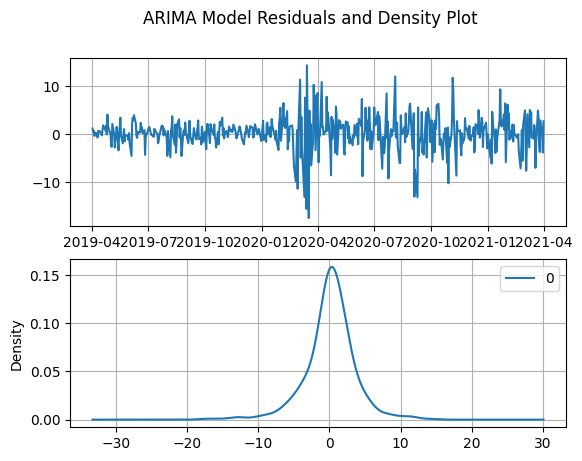

                0
count  505.000000
mean     0.133050
std      3.543847
min    -17.445956
25%     -1.235562
50%      0.308014
75%      1.852234
max     14.244986


In [164]:
# Extracting the residuals from the ARIMA model
residuals = pd.DataFrame(results_ARIMA.resid)

# sample the residuals from 2019 onwards 
residuals = residuals.loc['2019-04-01 16:00:00':]

# Creating 2 plots one for the residuals plot and one for the density plot
fig, axs = plt.subplots(2)
fig.suptitle('ARIMA Model Residuals and Density Plot')

# Plot the residuals in the first subplot and add a grid
axs[0].plot(residuals)
axs[0].grid(True)

# Plot a Kernel Density Estimate (KDE) of the residuals in second plot
residuals.plot(kind='kde', ax=axs[1])
axs[1].grid(True)
plt.show()

# Print the residuals
print(residuals.describe())

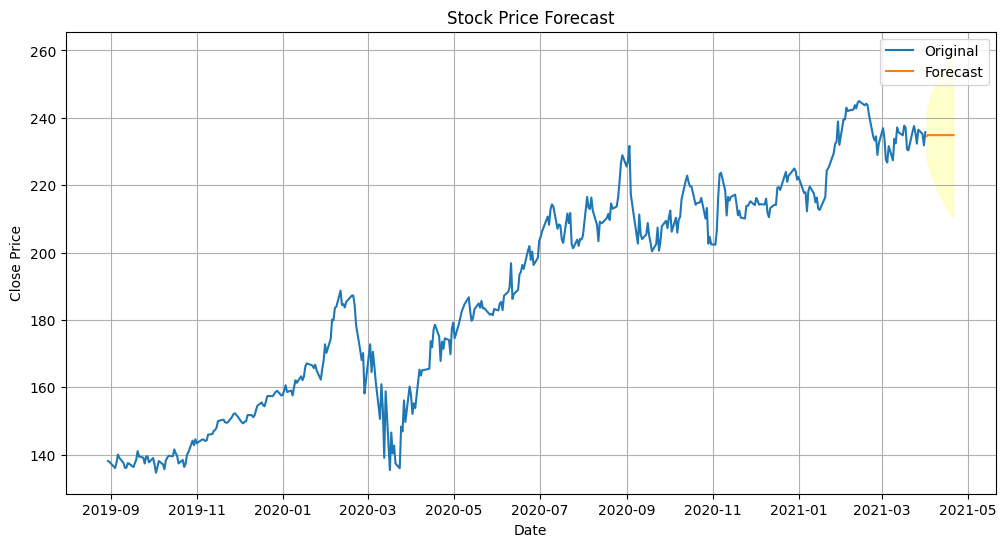

In [165]:
# using a start date based on findings to date '2019-04-01 16:00:00' onwards
time_series = time_series.loc['2019-04-01 16:00:00':]

# Fit the ARIMA model
model = ARIMA(time_series, order=(1, 1, 0))
results_ARIMA = model.fit()

# Forecasting

forecast_steps = 20 #Steps forward to forecast
forecast_results = results_ARIMA.get_forecast(steps=forecast_steps)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Adjusting the date index for the forecast plot
last_date = time_series.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1)[1:] #-day1

# Plotting the Forecast
plt.figure(figsize=(12,6))
plt.plot(time_series[-400:], label='Original')  # last 400 data points of the original time series
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.2)
plt.legend()
plt.title('Stock Price Forecast')
plt.xlabel('Date')  # Add x-axis label
plt.ylabel('Close Price')  # Add y-axis label
plt.grid(True)
plt.show()

In [166]:
# Calculate forecast errors
true_values = df['Close'][-forecast_steps:] 
mse = mean_squared_error(true_values, forecast)
mae = mean_absolute_error(true_values, forecast)
rmse = math.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 2.5976309899867376
Mean Squared Error: 11.015388718709598
Root Mean Squared Error: 3.318943916174179


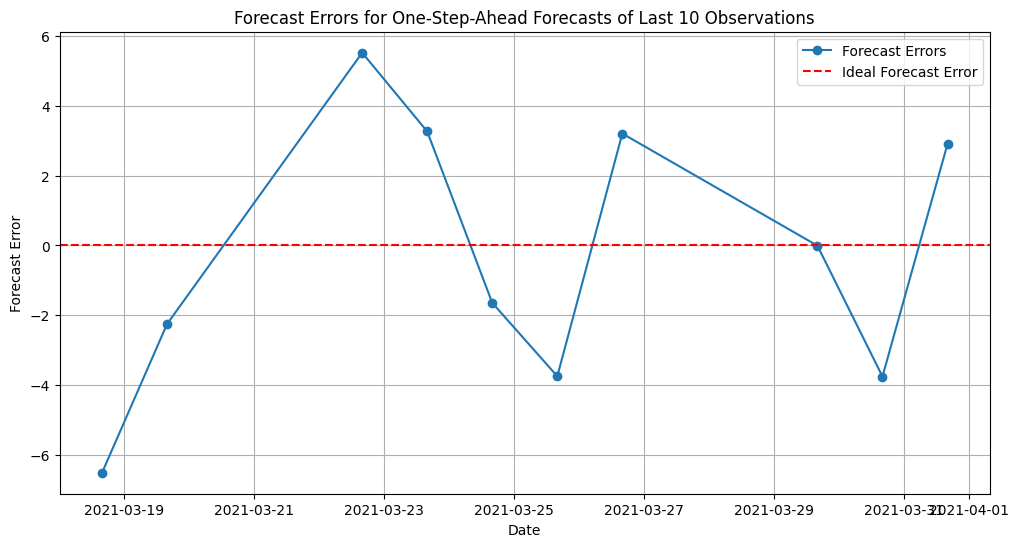

Date
2021-03-18 16:00:00   -6.519599
2021-03-19 16:00:00   -2.252781
2021-03-22 16:00:00    5.529774
2021-03-23 16:00:00    3.270203
2021-03-24 16:00:00   -1.646326
2021-03-25 16:00:00   -3.751566
2021-03-26 16:00:00    3.210526
2021-03-29 16:00:00   -0.006659
2021-03-30 16:00:00   -3.759406
2021-03-31 16:00:00    2.910091
dtype: float64


In [167]:
# One-step-ahead forecasts of the last 10 observations
one_step_forecast = results_ARIMA.get_prediction(start=-10)

# Get the predicted means and the confidence intervals
predicted_mean = one_step_forecast.predicted_mean
# Calculate the forecast errors
forecast_errors = time_series[-10:] - predicted_mean

# Plotting the Forecast Errors
plt.figure(figsize=(12,6))
plt.plot(forecast_errors, label='Forecast Errors', marker='o')

# Plot a horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='--', label='Ideal Forecast Error')

# Plot the error bounds
plt.title('Forecast Errors for One-Step-Ahead Forecasts of Last 10 Observations')
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecast errors
print(forecast_errors)

In [168]:
# Plotting interactive time series plot time
trace = go.Scatter(
    x = diff_time_series.index,
    y = diff_time_series,
    mode = 'lines',
    name = 'diff_time_series'
)

data = [trace]

# Create a layout
layout = go.Layout(
    title='Time Series Plot',
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Value'
    )
)

# Create a Figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show()

<Figure size 1200x600 with 0 Axes>

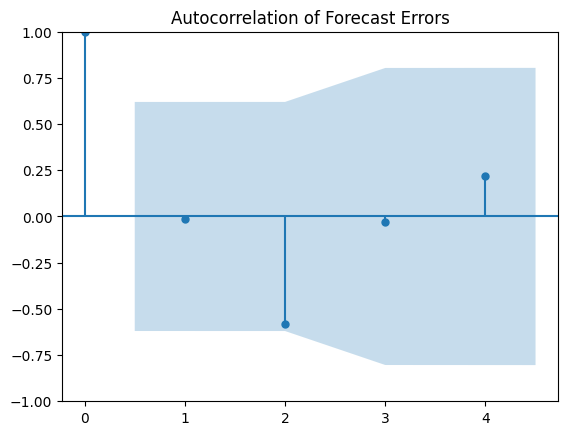

<Figure size 1200x600 with 0 Axes>

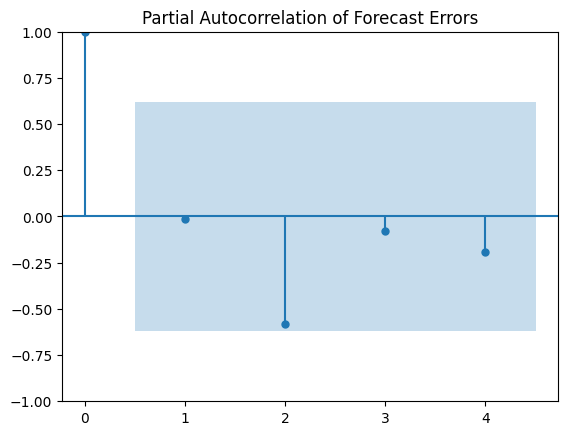

In [169]:
# Calculate and plot the Autocorrelation
plt.figure(figsize=(12,6))
plot_acf(forecast_errors, lags=min(10, len(forecast_errors)//2 - 1), title='Autocorrelation of Forecast Errors')
plt.show()

# Calculate and plot the Partial Autocorrelation
plt.figure(figsize=(12,6))
plot_pacf(forecast_errors, lags=min(10, len(forecast_errors)//2 - 1), title='Partial Autocorrelation of Forecast Errors')
plt.show()

#Sarimax below to show no seasonality of Data
I tried running Sarimax but loop with p,q, d values of 5 were too long, used AIC again 

In [170]:

# Initialize an empty list to store the AIC values and corresponding p, d, q values
aicVals = []

# Loop p, d, and q for the SARIMAX model, based on AIC premium number is 2
for p in range(2):
    for d in range(2):
        for q in range(2):
            try:
                # Fit a SARIMAX model in order (p, d, q) 
                # Calculate the AIC of the fitted model
                aic = SARIMAX(df["Close"], order=(p,d,q)).fit().aic
                
                # Append the AIC and corresponding p, d, q values to the list
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                # If the SARIMAX model cannot be fitted due to a Linear Algebra error, skip this combination of p, d, q
                pass

# Sort p, d, q values in ascending order of AIC
aicVals.sort()

# Print the best AIC 
print(f"Best AIC: {aicVals[0][0]}")
print(f"Best parameters: {aicVals[0][1:]}")

Best AIC: 6766.262644773562
Best parameters: [1, 1, 0]


In [171]:
# Initialize an empty list to store the AIC values and corresponding p, d, q values
aicVals = []

# Loop p, d, and q for the SARIMAX model, based on AIC premium number is 2
for p in range(3):  # change here
    for d in range(3):  # change here
        for q in range(3):  # change here
            try:
                # Fit a SARIMAX model in order (p, d, q) 
                # Calculate the AIC of the fitted model
                aic = SARIMAX(df["Close"], order=(p,d,q)).fit().aic
                
                # Append the AIC and corresponding p, d, q values to the list
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                # If the SARIMAX model cannot be fitted due to a Linear Algebra error, skip this combination of p, d, q
                pass

# Sort p, d, q values in ascending order of AIC
aicVals.sort()

# Print the best AIC 
print(f"Best AIC: {aicVals[0][0]}")
print(f"Best parameters: {aicVals[0][1:]}")


Best AIC: 6751.747544954895
Best parameters: [2, 2, 2]


In [172]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the p, d, q parameters based on the best AIC
p = 2
d = 2
q = 2

# Create the model
model = SARIMAX(df['Close'], order=(p,d,q))

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -3370.874
Date:                Sat, 25 Nov 2023   AIC                           6751.748
Time:                        18:14:04   BIC                           6778.344
Sample:                             0   HQIC                          6761.653
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1711      0.029    -40.613      0.000      -1.228      -1.115
ar.L2         -0.2909      0.010    -30.329      0.000      -0.310      -0.272
ma.L1         -0.1054      0.029     -3.579      0.0

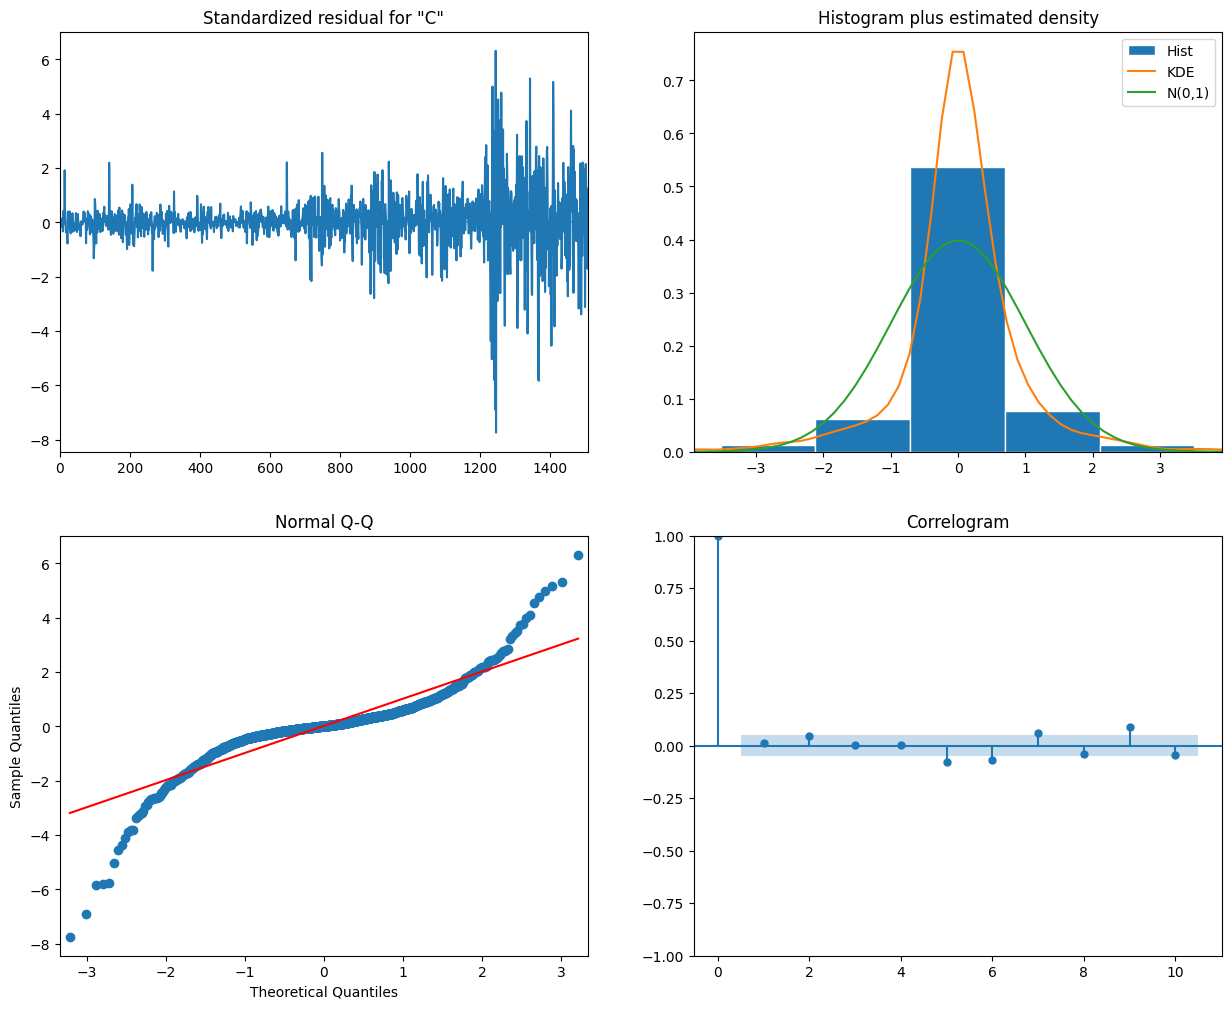

Mean Absolute Error: 1.3598508355930983
Root Mean Squared Error: 2.5419786924869827


In [173]:
# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make predictions
pred = results.get_prediction(start=pd.to_datetime('2015-04-01 16:00:00'), dynamic=False)
pred_conf = pred.conf_int()

# Calculate performance metrics
actual = df['Close']['2015-04-01 16:00:00':]
predicted = pred.predicted_mean
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Within this plot you can observere there is no real seasonality as such, hence Arima is a better fit for this specific obersation and dataset.